In [1]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from sklearn.decomposition import PCA
# import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
# %matplotlib notebook
from matplotlib.ticker import MaxNLocator
# import shap
import random
import itertools
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

assays = ['H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K9me3']
assay_index_choice = 5 # 1-based

RESOLUTION = 25
window_size = 401
operative_half_window_size = 84 # will lead to a total of the central 2*operative_half_window_size + 1 features being chosen
pairwise_flag = True # If true then H3K27ac features will be concatentated with assays[assay_index_choice-1]
if(pairwise_flag):
    pairwise_multiplier = 0
else:
    pairwise_multiplier = 1


In [2]:
colnames = ["pos_" + str(x) for x in list(range(-(window_size//2), (window_size//2) + 1))]
colnames = colnames + ["log10p1(TPM)", "cell_type", "chrom", "position", "strand", "assay_index"] 
df = pd.read_csv('../../Data/Training_Data.T13.sorted.csv', sep=",", names=colnames, low_memory=False)
df_sorted = df.sort_values(['chrom', 'position', 'cell_type', 'assay_index'], ascending=[1, 1, 1, 1])
df_sorted_unique = df_sorted.drop_duplicates()
df_H3K27ac = df_sorted_unique.iloc[range(3-1, len(df_sorted_unique), len(assays)), :]
df_other_assay = df_sorted_unique.iloc[range(assay_index_choice-1, len(df_sorted_unique), len(assays)), :]
df_merged = pd.merge(df_H3K27ac, df_other_assay, how='inner', on=['cell_type', 'chrom', 'position', 'strand'], suffixes=['_H3K27ac', '_'+assays[assay_index_choice-1]])


In [3]:
df_merged

,pos_-200_H3K27ac,pos_-199_H3K27ac,pos_-198_H3K27ac,pos_-197_H3K27ac,pos_-196_H3K27ac,pos_-195_H3K27ac,pos_-194_H3K27ac,pos_-193_H3K27ac,pos_-192_H3K27ac,pos_-191_H3K27ac,...,pos_193_H3K4me3,pos_194_H3K4me3,pos_195_H3K4me3,pos_196_H3K4me3,pos_197_H3K4me3,pos_198_H3K4me3,pos_199_H3K4me3,pos_200_H3K4me3,log10p1(TPM)_H3K4me3,assay_index_H3K4me3
0,0.316077,0.316077,0.316077,0.316077,0.316077,0.316077,0.316077,0.316077,0.316077,0.316077,...,0.334390,0.334390,0.334390,0.334390,0.334390,0.334390,0.334390,0.334390,0.000000,6
1,0.347780,0.347780,0.347780,0.347780,0.341266,0.345180,0.347780,0.330775,0.309184,0.315904,...,0.370928,0.367967,0.329625,0.329625,0.329625,0.329016,0.328963,0.328963,0.000000,6
2,0.306958,0.314752,0.334708,0.347780,0.347780,0.347780,0.347780,0.354836,0.360217,0.316077,...,1.025383,1.519954,1.886222,2.355392,2.762295,2.854675,2.750122,2.590550,0.000000,6
3,0.291124,0.306958,0.314752,0.334708,0.347780,0.347780,0.347780,0.347780,0.354836,0.360217,...,0.973407,1.025383,1.519954,1.886222,2.355392,2.762295,2.854675,2.750122,0.030907,6
4,0.340255,0.309993,0.309993,0.308295,0.304677,0.335909,0.465741,0.495241,0.471743,0.471743,...,0.427109,0.421649,0.421649,0.431492,0.409359,0.378069,0.364046,0.444377,0.015702,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10616,0.376839,0.376839,0.376839,0.355413,0.316077,0.316077,0.316077,0.315170,0.304677,0.304677,...,0.318368,0.324301,0.322446,0.322446,0.317246,0.312797,0.314606,0.315265,0.019116,6
10617,0.700017,0.699565,0.542461,0.417476,0.355896,0.314752,0.314752,0.416417,0.402891,0.349657,...,0.320006,0.325803,0.337139,0.326010,0.332677,0.320006,0.320006,0.317424,1.399599,6
10618,0.347930,0.349657,0.349657,0.349657,0.349657,0.349432,0.489826,0.491086,0.490912,0.430403,...,0.315265,0.315265,0.317193,0.317208,0.316534,0.316515,0.316515,0.316624,1.389310,6
10619,0.360415,0.313968,0.355872,0.372297,0.373225,0.373225,0.527495,0.500064,0.514241,0.696790,...,0.504212,0.432881,0.401791,0.399841,0.347673,0.322835,0.322835,0.322835,0.000000,6


(9474, 338) (4877, 338) (9474,) (4877,)
Train: MSE =  0.177 Pearson = 0.675 Spearman = 0.717
Test: MSE =  0.187 Pearson = 0.649 Spearman = 0.694


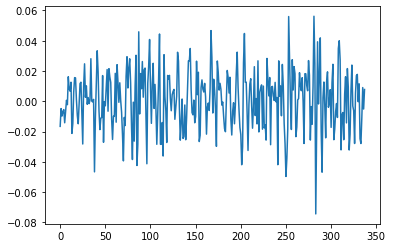

In [4]:
middle_position_first_feature = window_size // 2
middle_position_second_feature = -1 + ( (window_size + 6) + (window_size + 6 + window_size + 1) )//2

df_two_assays = df_merged.iloc[:, 
                               np.r_[middle_position_first_feature-(operative_half_window_size):
                                     middle_position_first_feature+(operative_half_window_size)+1, 
                                     middle_position_second_feature-(operative_half_window_size):
                                     middle_position_second_feature+(operative_half_window_size)+1,
                                     window_size,
                                     window_size + 1,
                                     window_size + 2,
                                     window_size + 3]]

df_subsampled = df_two_assays

# Train on all but CXCR4 and TGFBR1 chromosomes
training_chromosomes = ["chr" + str(c) for c in range(1, 23, 1)]
training_chromosomes.remove("chr2") # exclude chr2 where CXCR4 lies
training_chromosomes.remove("chr9") # exclude chr2 where TGFBR1 lies

df_training = df_subsampled.loc[df_subsampled['chrom'].isin(training_chromosomes)]
xTrain = df_training.iloc[:, pairwise_multiplier*(2 * operative_half_window_size + 1):2 * (2 * operative_half_window_size + 1)] 
yTrain = df_training.iloc[:, 2 * (2 * operative_half_window_size + 1)]

testing_chromosomes = ["chr" + str(c) for c in range(2, 23, 2)]
df_testing = df_subsampled.loc[df_subsampled['chrom'].isin(testing_chromosomes)]
xTest = df_testing.iloc[:, pairwise_multiplier*(2 * operative_half_window_size + 1):2 * (2 * operative_half_window_size + 1)] 
yTest = df_testing.iloc[:, 2 * (2 * operative_half_window_size + 1)]

if(len(xTrain) < 10):
    print("len(xTrain) = "+str(len(xTrain)))

quadratic_transform = PolynomialFeatures(degree=1, interaction_only=True).fit(xTrain)
# xTrain = quadratic_transform.transform(xTrain)
# xTest = quadratic_transform.transform(xTest)

# The quadratic transform step adds an additional feature to the input features
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

# Fit a ridge regression model
l1_alpha = 0.01
model = linear_model.ElasticNet(alpha=l1_alpha, l1_ratio=0.0, max_iter=1000)

xTrain = np.asarray(xTrain)
yTrain = np.asarray(yTrain)
xTest = np.asarray(xTest)
yTest = np.asarray(yTest)

model.fit(xTrain, yTrain)

# Compute statistics
yTrain_Pred = model.predict(xTrain)
yTest_Pred = model.predict(xTest)
mse_Train = mean_squared_error(yTrain, yTrain_Pred)
pc_Train, _ = pearsonr(yTrain, yTrain_Pred)
sc_Train, _ = spearmanr(yTrain, yTrain_Pred)
mse_Test = mean_squared_error(yTest, yTest_Pred)
pc_Test, _ = pearsonr(yTest, yTest_Pred)
sc_Test, _ = spearmanr(yTest, yTest_Pred)

print("Train: MSE = ", round(mse_Train, 3), "Pearson =", round(pc_Train, 3), "Spearman =", round(sc_Train, 3))
print("Test: MSE = ", round(mse_Test, 3), "Pearson =", round(pc_Test, 3), "Spearman =", round(sc_Test, 3))

plt.plot(model.coef_)

Loading TSS data
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A02.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A03.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A04.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A05.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A06.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A07.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A10.chr2.npy
Loading Transcriptome data ../../Data/Gene_Expression_Data/25bp_genome_wide_TPM_npy/T13_TPM.chr2.+.npy ../../Data/Gene_Expression_Data/25bp_genome_wide_TPM_npy/T13_TPM.chr2.-.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A02.chr9.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A03.chr9.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A04.chr9.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A05.chr9.npy
Loading Epig

(1, 169, 7) (1, 1)


Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A03.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A04.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A05.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A06.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A07.chr2.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A10.chr2.npy
Loading Transcriptome data ../../Data/Gene_Expression_Data/25bp_genome_wide_TPM_npy/T13_TPM.chr2.+.npy ../../Data/Gene_Expression_Data/25bp_genome_wide_TPM_npy/T13_TPM.chr2.-.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A02.chr9.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A03.chr9.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A04.chr9.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A05.chr9.npy
Loading Epigenome data ../../Data/Transformed_25bp_Data/T13A06.chr9.npy
Loading Epigenome data ../../

(1, 169, 7) (1, 1)


100%|██████████| 992/992 [00:00<00:00, 9022.47it/s]


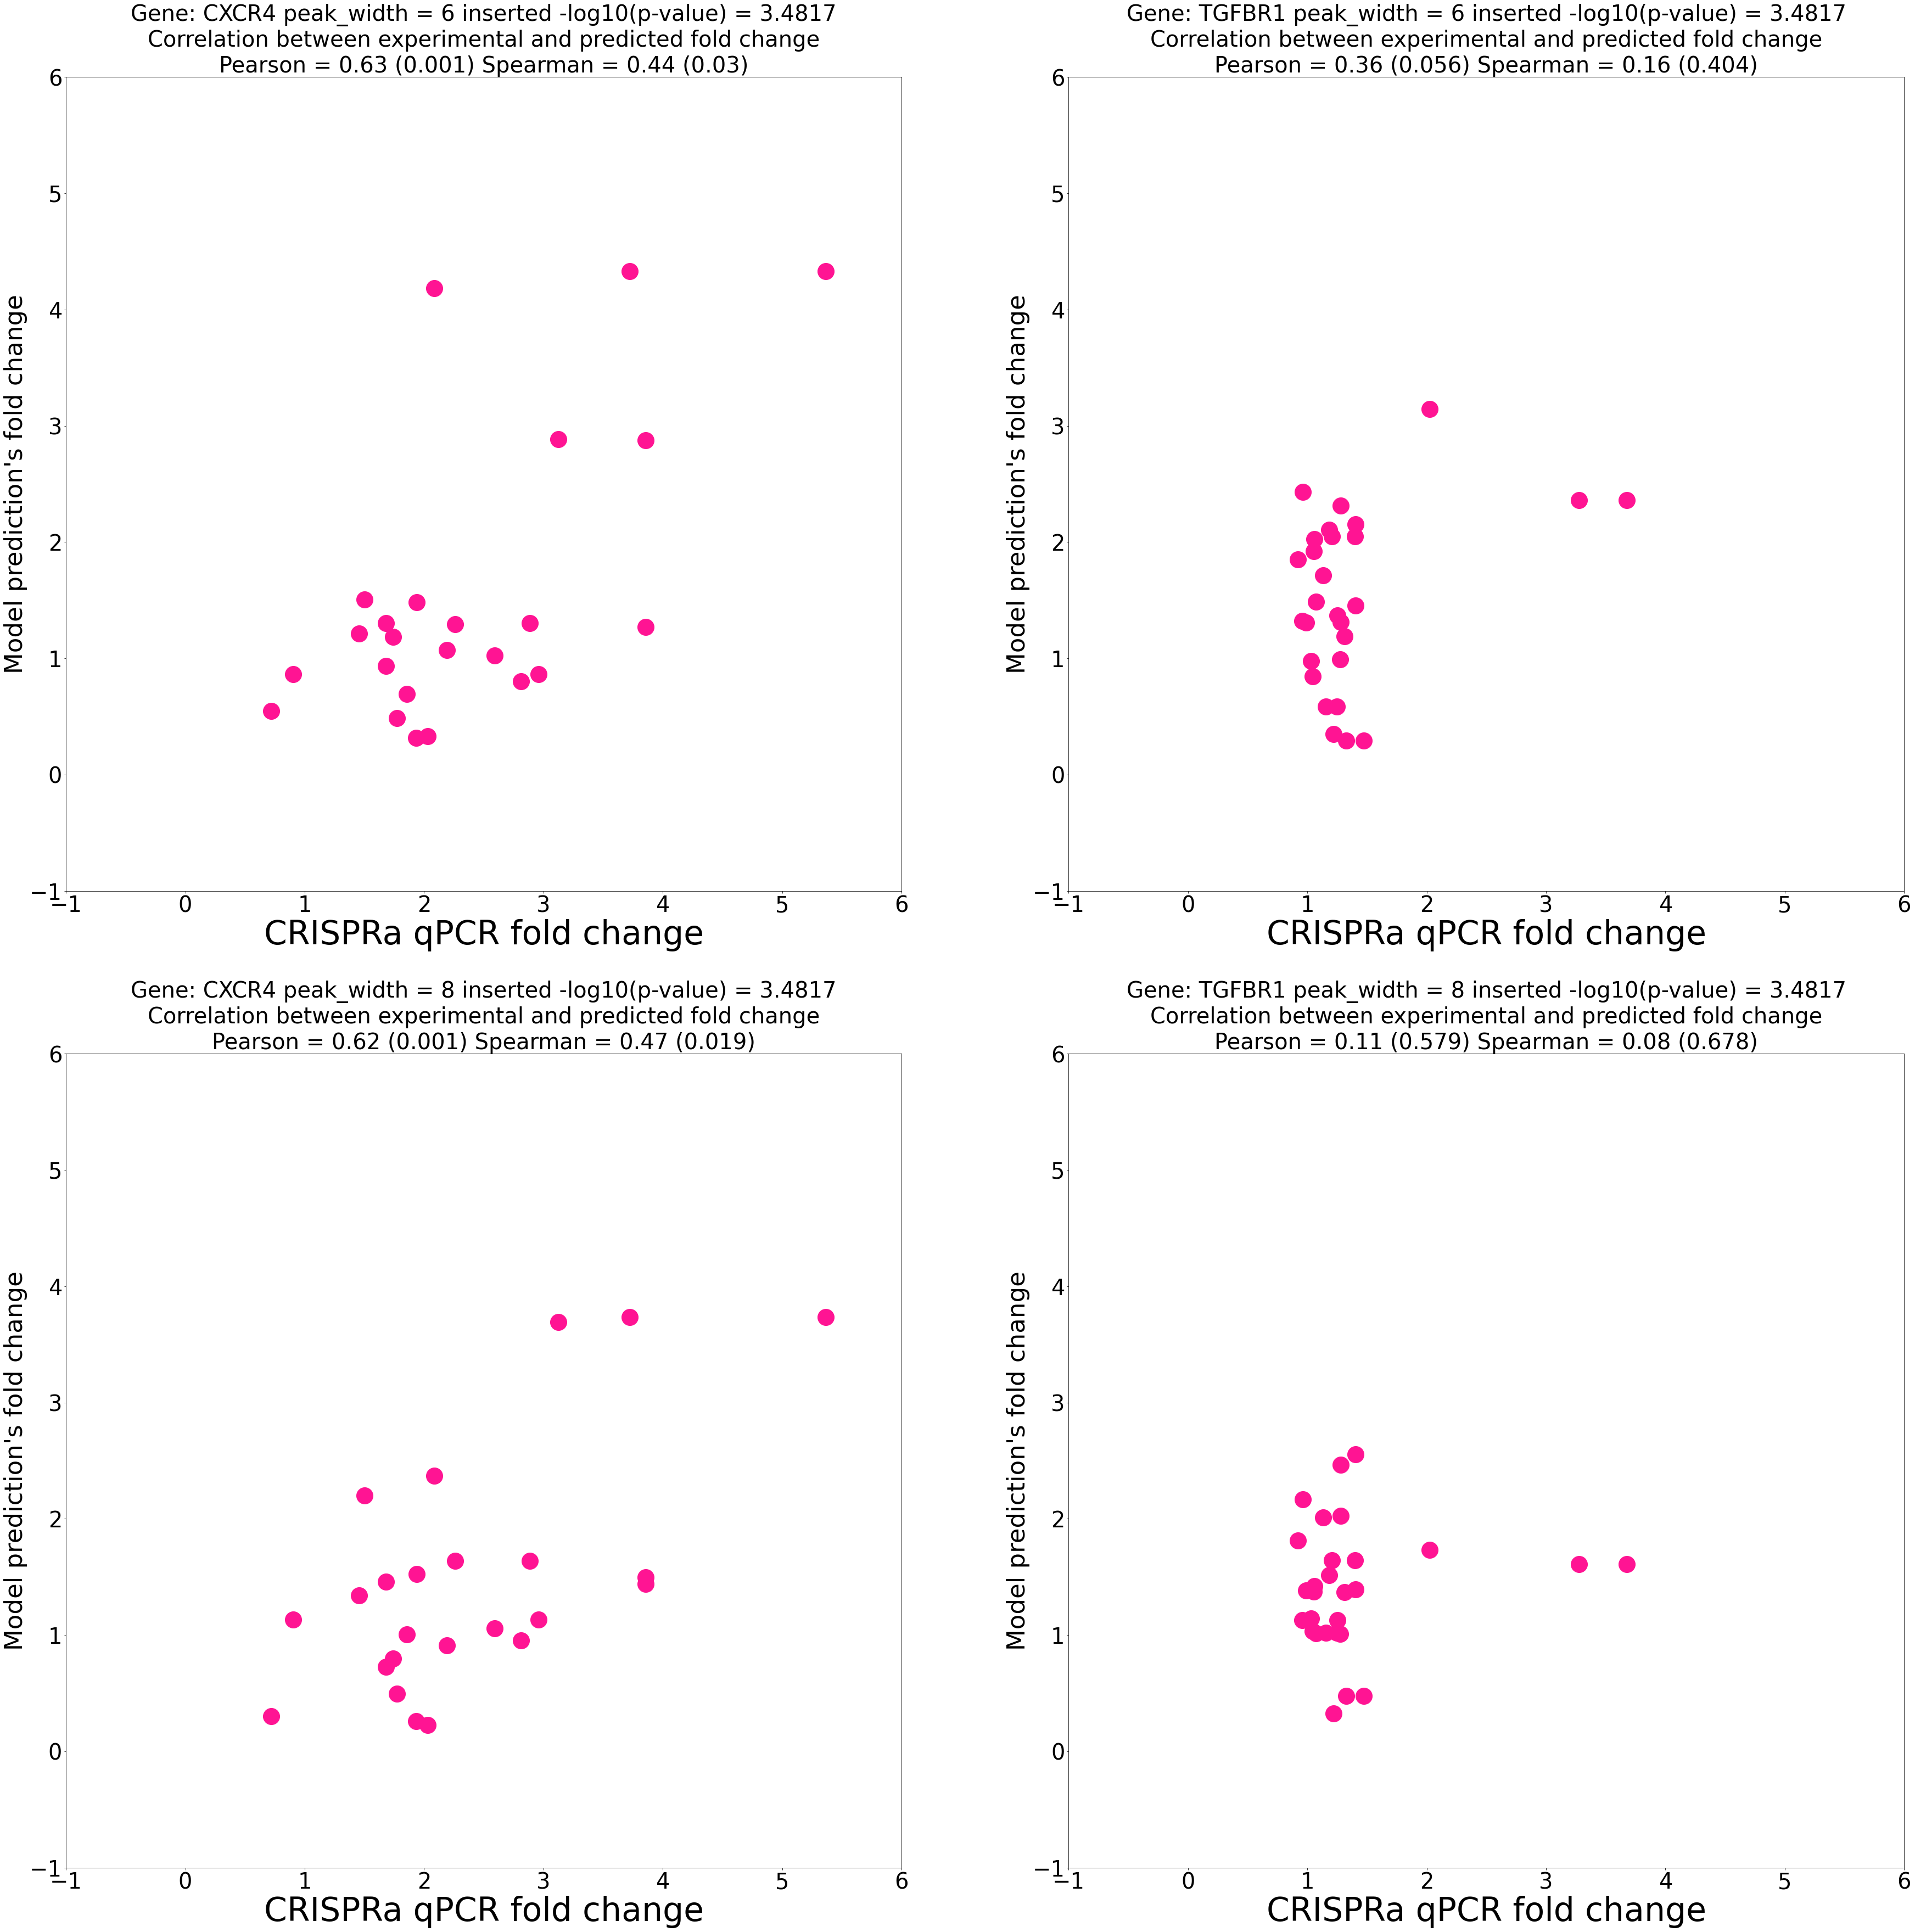

In [5]:
sys.path.insert(1, '/home/sbatra/.chrmt/Code/deepENCODE/')
from chrmt_inference import generate_data_vectors
from chrmt_inference import ise_pairwise_input
from chrmt_inference import perform_ise

# use above ridge regression model
trained_model = model

# Generate data vectors for CXCR4 and TGFBR1
cell_type_choice = -1
path_to_save = "../../Data/" + "linear_model"
xInference, yInference, gene_list, CHROM, TSS, STRAND = generate_data_vectors(cell_type_choice, 2 * operative_half_window_size + 1, path_to_save)

peak_width_choices = [6, 8]
inserted_lnp1_minuslog10_p_value_choices = [1.5]  # corresponds to 0.0003
fig, axs = plt.subplots(len(peak_width_choices) * len(inserted_lnp1_minuslog10_p_value_choices), 2)

fig = perform_ise(fig, axs,
            2 * operative_half_window_size + 1,
            "../../Data/p300_epigenome_editing_dataset.tsv", ise_pairwise_input,
            peak_width_choices,
            inserted_lnp1_minuslog10_p_value_choices,
            xInference, yInference,
            gene_list, CHROM, TSS, STRAND,                
            trained_model)

fig.show()

In [6]:
# The goal is to perform in-silico perturbation using a model trained to predict bulk gene expression from 
# epigenetic features, on CRISPRa data

cell_type_choice = 13 # corresponds to HEK293T
assay_index = assay_index_choice

inserted_pvalue_choice = 1.5 # corresponds to 0.0003
for peak_width_choice in range(6, 7, 2):
    
    for MNase_offset in range(-15, 15):
#         print("peak_width = ", peak_width_choice)
        TPM = {}

        # Perform inference for epigenome editing data
        def ise(cell_type_choice_input, 
                gene,
                gene_strand,
                gRNA_strand_dict,
                trained_model,
                assay_index_value,
                inserted_lnp1_minuslog10p_value = 3,
                peak_width = 2,
                pairwise_features=False):

            # Load epigenetic features for all assays
            X = np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice_input + ".npy")

            # obtain the middle portion of this
            X = X[:, (window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

            # Perform inference by introducing p-value changes with a peak width
            yPred = []
            center = operative_half_window_size
            positions = range(center - center, center + center + 1)
            for pos in positions:
                X_modified = np.copy(X)

                # some positions won't be used in the plot and hence we don't perturb them
                if(pos not in gRNA_strand_dict):
                    gRNA_strand = "plus" # Change 1
                else:
                    gRNA_strand = gRNA_strand_dict[pos]

                ise_start_position = pos - (peak_width // 2)
                ise_end_position = pos + (peak_width // 2 + 1) 

                for p in range(ise_start_position, ise_end_position):
                    if( (p>=0) and (p < max(positions)) ):
                        if(X_modified[:, p, 2] > 10): # Remember this is ln( -log10(p-value) + 1)
                            # If H3K27me3 peak exists, then p300 doesn't work
                            print("H3K27me3 exists!")
                            pass
                        else:
                            if (pairwise_features):
                                # Modify the H3K27ac peak with the shape being derived from MNase (-1) 
                                if(gRNA_strand == "plus"):
                                    X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, min(p+MNase_offset, 2*operative_half_window_size), -1] * inserted_lnp1_minuslog10p_value)
#                                     print("Delta = ", gene, peak_width_choice, gRNA_strand, pos, p, (X_modified[:, min(p+MNase_offset, 2*operative_half_window_size), -1]), file=sys.stderr)
                                else: #(gRNA_strand == "minus"):
                                    X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, min(p-MNase_offset, 2*operative_half_window_size), -1] * inserted_lnp1_minuslog10p_value)
#                                     print("Delta = ", gene, peak_width_choice, gRNA_strand, pos, p, (X_modified[:, min(p-MNase_offset, 2*operative_half_window_size), -1]), file=sys.stderr)
#                                 else:
#                                     pass # Change 2
                            else:
                                # Modify the assay itself
                                X_modified[:, p, assay_index_value] += inserted_lnp1_minuslog10p_value

                # Prepare input
                if (pairwise_features):
                    X_modified = np.concatenate([X_modified[:, :, 3], X_modified[:, :, assay_index_value]], axis=1)
                else:                 
                    X_modified = X_modified[:, :, assay_index_value]

                yPred_value = trained_model.predict(quadratic_transform.transform(X_modified))
                yy = yPred_value[0]
                yPred.append(yy)

            # Prepare input for predicting native expression
            X_modified_2 = np.copy(X)
            if(pairwise_features):
                X_modified_2 = np.concatenate([X[:, :, 3], X[:, :, assay_index_value]], axis=1) 
            else:
                X_modified_2 = X[:, :, assay_index_value]

            # Instead of scaling, divide by yPred
            yPred_value = trained_model.predict(quadratic_transform.transform(X_modified_2))[0] + 0.00000001 # to avoid divby0

        #             print("Predicted TPM for ", gene, " = ", yPred_TPM)
        #             print((np.power(10, yPred) -1), (np.power(10, yPred_value) -1))

            yPred = (np.power(10, yPred) -1) / (np.power(10, yPred_value) -1)
            yPred_TPM = (np.power(10, yPred_value) -1)
            return yPred, yPred_TPM


        def p_value_mapping(inserted_lnp1_minuslog10p_value):
            minuslog10p_value = np.expm1(inserted_lnp1_minuslog10p_value)
            p_value = np.power(10, -1 * minuslog10p_value)
            return round(minuslog10p_value, 4)


        def convert_to_2D(idx, nrows, ncols):
            return idx//ncols, idx%ncols


        # Now that we have the helper functions declared, we perform the in silico perturbation

        # Load p300 epigenome editing data
        df_p300_epigenome_editing = pd.read_csv("../Data/p300_epigenome_editing_dataset.tsv", sep="\t")

        # we want to compute 
        TSS = {}
        STRANDS = {}
        CHROMS = {}
        GENES = {}
        gRNA_STRANDS = {}
        for index in range(len(df_p300_epigenome_editing)):
            tss = df_p300_epigenome_editing.iloc[index, 13]
            gene_strand = df_p300_epigenome_editing.iloc[index, 3]
            chrom = df_p300_epigenome_editing.iloc[index, 2]
            gene = df_p300_epigenome_editing.iloc[index, 0]

            TSS[gene] = int(tss)

            if(gene_strand == "plus"):
                STRANDS[gene] = "+"
            elif(gene_strand == "minus"):
                STRANDS[gene] = "-"
            else:
                print("something wrong with strand!")

            CHROMS[gene] = chrom
            GENES[gene] = 1                                                    

        GENES_LIST = set(list(GENES.keys()))    

        df_GENES_values = {}
        df_GENES_means = {}
        gene_strand_dict = {}
        for gene in GENES_LIST:
            df_GENES_values[gene] = df_p300_epigenome_editing[df_p300_epigenome_editing["p300 target gene"] == gene]

            df_GENES_values[gene]["Position_wrt_TSS"] = ( (pd.to_numeric(df_GENES_values[gene]["gRNA position  wrt TSS (hg38)"])) / RESOLUTION ) # Change 3

            df_GENES_values[gene]["gRNA_strand"] = df_GENES_values[gene]["gRNA target strand"].apply(lambda s: "red" if(s=="minus") else "blue")
            df_GENES_values[gene]["gRNA_strand_bool"] = df_GENES_values[gene]["gRNA target strand"].apply(lambda s: -1 if(s=="minus") else +1)

            gene_strand_dict[gene] = STRANDS[gene]
        #     print(gene_strand_dict)

            df_GENES_means[gene] = df_GENES_values[gene].groupby('gRNA ID').mean()
            df_GENES_means[gene].index.name = 'gRNA ID'
            df_GENES_means[gene].reset_index(inplace=True)
#             print(gene, df_GENES_means[gene])

        # Perform in-silico epigenesis
        assay_color = ['black', 'red', 'green', 'blue', 'cyan', 'pink', 'brown']
        xticklabels = range(-operative_half_window_size, operative_half_window_size + 1)

        GENES_LIST = ["CXCR4", "TGFBR1"]

        fig, axes = plt.subplots(nrows=len(GENES_LIST), ncols=2, figsize=(40, 30), sharey=False)
        fig.tight_layout(pad=1, w_pad=20, h_pad=25)

        for idx, gene in enumerate(sorted(GENES_LIST)):
            TPM[gene] = {}

            idx_x, idx_y = convert_to_2D(idx, nrows=len(GENES_LIST), ncols=1)
            ax_1 = axes[idx_x, 0]
            ax_2 = axes[idx_x, 1]

            gene_features = np.squeeze(np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice + ".npy"), axis=0)
            gene_features = gene_features[(window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

            df_values = df_GENES_values[gene]
            df_means = df_GENES_means[gene]
            # print(gene, df_values) 
            # print(gene, df_means)

            inserted_lnp1_minuslog10p_value = inserted_pvalue_choice
            peak_width = peak_width_choice

            # Compute gRNA strands for all positions
            gRNA_strand_dict = {}
            for p_idx in range(len(df_means)):
                position_m = int( (df_means.iloc[p_idx, 9] + operative_half_window_size) )
                gRNA_strand = df_means.iloc[p_idx, 10]
                if(gRNA_strand == +1):
                    gRNA_strand_dict[position_m] = "plus"
                elif(gRNA_strand == -1):
                    gRNA_strand_dict[position_m] = "minus"
                else:
                    print("Something wrong with parsing gRNA strand", file=sys.stderr)

            # Pass assay_index as -1 to make sure we select MNase
            gene_ise, yPred_TPM = ise(cell_type_choice, gene, gene_strand_dict[gene], gRNA_strand_dict, model, 1*assay_index - 1, inserted_lnp1_minuslog10p_value, peak_width, pairwise_flag)

            # Create a scatter plot of the means with the predictions of those positions
            gene_ise_at_means = []
            alan_means = []
            gRNA_strands = []

            for p_idx in range(len(df_means)):
                position_m = df_means.iloc[p_idx, 9]
                alan_mean = df_means.iloc[p_idx, 1]
                gRNA_strand = df_means.iloc[p_idx, 10]
                if(position_m + operative_half_window_size < 0):
                    continue
                elif( (int(position_m) + operative_half_window_size) >= len(gene_ise) ):
                    continue
                else:
        #             print(len(gene_ise), position_m, operative_half_window_size)
                    gene_ise_at_means.append(gene_ise[int(position_m) + operative_half_window_size])
                    alan_means.append(alan_mean)
                    gRNA_strands.append(gRNA_strand)

            pc, pp = pearsonr(list(alan_means), gene_ise_at_means)
            sc, sp = spearmanr(list(alan_means), gene_ise_at_means)

            print(gene, sc, sp, MNase_offset, file=sys.stderr)

            gRNA_strands_colors = []
            for iii in gRNA_strands:
                if(iii == -1):
                    gRNA_strands_colors.append("red")
                else:
                    gRNA_strands_colors.append("blue")

            ax_1.scatter(list(alan_means), gene_ise_at_means, color="#FF1493", s=1000) # ="#FF1493")
            ax_1.set_xlim(0, 1.1 * max(alan_means))
            ax_1.set_ylim(0, 1.1 * max(gene_ise_at_means))
            ax_1.tick_params(axis='both', which='major', labelsize=40)
            ax_1.tick_params(axis='both', which='minor', labelsize=40)
            ax_1.set_xlabel("Mean experimental fold change", size=60)
            ax_1.set_ylabel("Model prediction's fold change", size=45)
        #     if(pp > 0.05):
        #         p_asterisk = "NS"
        #     if(sp > 0.05):
        #         s_asterisk = "NS"
            ax_1.set_title("Correlation between experimental and model predictions fold change\nPearson = "+
                           str(round(pc, 2))+
                           " ("+str(round(pp, 3))+
                           ") Spearman = "+
                           str(round(sc, 2))+
                           " ("+str(round(sp, 3))+
                           ")", size=40)

            # Determine whether we are doing H3K27ac ISE in the background of another assay's features
            # or we have marginal features and are doing that track's ISE
            if(pairwise_flag):
                epigenetic_features = gene_features[:, -1] # MNase
                epigenetic_features_2 = gene_features[:, 3] # H3K27ac
                color_for_assay = assay_color[3]
                label_for_assay = assays[3]
            else:
                epigenetic_features = gene_features[:, assay_index-1]
                color_for_assay = assay_color[assay_index-1]
                label_for_assay = assays[assay_index-1]

            # Scale the model predictions     
            scaling_ratio = np.median(df_means['Measured fold change'])/np.median(gene_ise - 0.0)
            scaled_model_predictions = 0.5 * (scaling_ratio * (gene_ise - 0.0)) + 1.0

            # Scale the epigenetic features
            epigenetic_features_scaling_ratio = max(df_means['Measured fold change'])/max(epigenetic_features - 0.0)
            scaled_epigenetic_features = (epigenetic_features_scaling_ratio * (epigenetic_features - 0.0)) + 0.5

            epigenetic_features_scaling_ratio_2 = max(df_means['Measured fold change'])/max(epigenetic_features_2 - 0.0)
            scaled_epigenetic_features_2 = (epigenetic_features_scaling_ratio_2 * (epigenetic_features_2 - 0.0)) + 0.0 

            ax_2.plot(xticklabels, scaled_model_predictions, 'o-', color="#4daf4a", linewidth=5, markersize=2, label="(Scaled) Model Predictions " + label_for_assay)
            ax_2.plot(xticklabels, scaled_epigenetic_features, 'o-', color="#8470FF", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features MNase") # + label_for_assay)
            ax_2.plot(xticklabels, scaled_epigenetic_features_2, 'o-', color="darkblue", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features H3K27ac") # + label_for_assay)

            ax_2.bar(df_means['Position_wrt_TSS'], 0.0 + (df_means['Measured fold change']), color="#f781bf", bottom=0, width=2, label="Experimental mean from qPCR")

            gRNA_strand_groups = df_values.groupby("gRNA target strand")

            color_dict = {}
            color_dict["+"] = {"plus":"blue", "minus":"red"}
            color_dict["-"] = {"plus":"red", "minus":"blue"}
            direction = {"blue":"rightward", "red":"leftward"}
            color_index = 0
            for name, group in gRNA_strand_groups:
                ax_2.plot(group['Position_wrt_TSS'], 0.0 + (group['Measured fold change']), 'o', color=color_dict[STRANDS[gene]][name], label="qPCR facing "+direction[color_dict[STRANDS[gene]][name]], markersize=15)
                color_index += 1

            ax_2.set_xlim(-operative_half_window_size-10, operative_half_window_size+10)
            ax_2.set_ylim(-1, 1.0 + max(df_means['Measured fold change'])*1.5)
            x_vals = ax_2.get_xticks()
            ax_2.set_xticklabels(['{:3.0f}'.format(x * RESOLUTION) for x in x_vals])
            ax_2.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax_2.tick_params(axis='both', which='major', labelsize=35)
            ax_2.tick_params(axis='both', which='minor', labelsize=35)
            ax_2.set_xlabel("Peak Position (in bp) w.r.t TSS", size=50)
            ax_2.set_ylabel("Gene expression fold change", size=50)
            ax_2.set_title(gene+" with H3K27ac + "+assays[assay_index-1]+"\nincreasing " + str(peak_width * RESOLUTION) + "bp peaks by -log10(p_value)="+str(p_value_mapping(inserted_lnp1_minuslog10p_value)), size=40) #, y=1.1)

            ax_2.legend(loc='upper center', prop={'size': 30}, ncol=2)

            # Now also keep storing the actual TPM vs predicted TPM for each gene, for each cell type
            actual_TPM = np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice + ".TPM.npy")
        #             print(gene, cell_type_choice, (np.power(10, actual_TPM[0][0]) -1), yPred_TPM)
            TPM[gene][cell_type_choice] = ((np.power(10, actual_TPM[0][0]) -1), yPred_TPM)

#         plt.show()
        plt.close()




FileNotFoundError: [Errno 2] No such file or directory: '../Data/p300_epigenome_editing_dataset.tsv'

In [ ]:
# Plot spearman as a function of MNase offset
plt.rcParams["figure.figsize"] = (20, 10)
colnames = ["gene", "sc", "sp", "offset"] 
df_offset = pd.read_csv('../Data/offset_Spearman.plus_plus', sep=" ", names=colnames, low_memory=False)
df_offset_sorted = df_offset.sort_values(['gene', 'offset'], ascending=[1, 1])
df_offset_sorted
plt.plot(df_offset_sorted.iloc[1:29, 3], df_offset_sorted.iloc[1:29, 1],  'o-', color="#4daf4a", linewidth=5, markersize=10, label="CXCR4")
plt.plot(df_offset_sorted.iloc[30:, 3], df_offset_sorted.iloc[30:, 1],  'o-', color="#8470FF", linewidth=5, markersize=10, label="TGFBR1")
plt.xlabel("Offset / 25bp ", fontsize=25)
plt.ylabel("Spearman of linear model's predictions with Alan's data", fontsize=20)
plt.xlim(-16, 16)
plt.ylim(-0.1, 1)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.title("(strand-specific) Offset to extract MNase-seq for perturbation", fontsize=35)
plt.legend(loc='upper right', prop={'size': 30}, ncol=2)
plt.show()
plt.close()

In [ ]:
# We analyze the HER2 gene dataset here:
colnames = ["chrom", "gRNA_start", "gRNA_end", "gRNA_ID", "average_log2(fold_change)", "d_TSS"] 
df_HER2_DHS = pd.read_csv('../Data/HER2.DHS.hg38.tsv', sep="\t", names=colnames, low_memory=False)
df_HER2_sat = pd.read_csv('../Data/HER2.sat.hg38.tsv', sep="\t", names=colnames, low_memory=False)
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(df_HER2_sat['d_TSS'], df_HER2_sat['average_log2(fold_change)'], 'o', color="skyblue", label="sat ("+str(len(df_HER2_sat))+" gRNAs)")
plt.plot(df_HER2_DHS['d_TSS'], df_HER2_DHS['average_log2(fold_change)'], 'o', color="red", label="DHS ("+str(len(df_HER2_DHS))+" gRNAs)")
plt.xlabel("distance of gRNA to TSS in bp", fontsize=25)
plt.ylabel("average(log2(fold-change)) between high and low expression", fontsize=20)
plt.xlim(-2100, 2100)
plt.ylim(-4, 4)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.title("HER2 NBT17", fontsize=35)
plt.legend(loc='upper center', prop={'size': 30}, ncol=2, markerscale=2)
plt.show()



In [ ]:
# Perform perturbation analysis in HER2
df_HER2_p300_epigenome_editing = pd.read_csv("../Data/HER2.p300_epigenome_editing_dataset.tsv", sep="\t")

def her2_ise(position, cell_type_choice, gene_features, gRNA_strand, trained_model, assay_index_value, inserted_lnp1_minuslog10p_value, peak_width):

    # Load epigenetic features for all assays
    X = gene_features

    # obtain the middle portion of this
    X = X[:, (window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

    # Perform inference by introducing p-value changes with a peak width
    yPred = []

    positions = [position + operative_half_window_size]
    for pos in positions:
        X_modified = np.copy(X)

        ise_start_position = max(0, pos - (peak_width // 2))
        ise_end_position = min(pos + (peak_width // 2 + 1), 2*operative_half_window_size)

        for p in range(ise_start_position, ise_end_position):
            if( (p>=0) and (p < max(positions)) ):
                if(X_modified[:, p, 2] > 10): # Remember this is ln( -log10(p-value) + 1)
                    # If H3K27me3 peak exists, then p300 doesn't work
                    print("H3K27me3 exists!")
                    pass
                else:
                    # Modify the H3K27ac peak with the shape being derived from MNase (-1) 
                    if(gRNA_strand == "plus"):
                        X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, min(p+MNase_offset, 2*operative_half_window_size), -1] * inserted_lnp1_minuslog10p_value)
#                         print("Delta = ", gene, peak_width_choice, gRNA_strand, pos, p, (X_modified[:, min(p+MNase_offset, 2*operative_half_window_size), -1]), file=sys.stderr)
                    elif(gRNA_strand == "minus"):
                        X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, min(p-MNase_offset, 2*operative_half_window_size), -1] * inserted_lnp1_minuslog10p_value)
#                         print("Delta = ", gene, peak_width_choice, gRNA_strand, pos, p, (X_modified[:, min(p-MNase_offset, 2*operative_half_window_size), -1]), file=sys.stderr)
                    else:
                        pass # Change 2

        # Prepare input
        X_modified = np.concatenate([X_modified[:, :, 3], X_modified[:, :, assay_index_value]], axis=1)

        yPred_value = trained_model.predict(quadratic_transform.transform(X_modified))
        yy = yPred_value[0]
        yPred.append(yy)

    # Prepare input for predicting native expression
    X_modified_2 = np.copy(X)
    X_modified_2 = np.concatenate([X[:, :, 3], X[:, :, assay_index_value]], axis=1) 
    
    # Instead of scaling, divide by yPred
    yPred_value = trained_model.predict(quadratic_transform.transform(X_modified_2))[0] + 0.00000001 # to avoid divby0

#             print("Predicted TPM for ", gene, " = ", yPred_TPM)
#             print((np.power(10, yPred) -1), (np.power(10, yPred_value) -1))

    yPred = (np.power(10, yPred) -1) / (np.power(10, yPred_value) -1)
    yPred_TPM = (np.power(10, yPred_value) -1)
    
    assert(len(yPred) == 1)
    
    return yPred[0]/yPred_TPM


cell_type_choice = 13 # corresponds to HEK293T
assay_index = assay_index_choice

inserted_pvalue_choice = 1.5 # corresponds to 0.0003
peak_width_choice = 6

for MNase_offset in range(-15,15):

    # Perform in-silico epigenesis
    assay_color = ['black', 'red', 'green', 'blue', 'cyan', 'pink', 'brown']
    xticklabels = range(-operative_half_window_size, operative_half_window_size + 1)

    GENES_LIST = ["HER2", "HER2"] # ["CXCR4", "TGFBR1"]

    fig, axes = plt.subplots(nrows=len(GENES_LIST), ncols=2, figsize=(40, 30), sharey=False)
    fig.tight_layout(pad=1, w_pad=20, h_pad=25)

    for idx, gene in enumerate(sorted(GENES_LIST)):
        TPM[gene] = {}

        idx_x, idx_y = convert_to_2D(idx, nrows=len(GENES_LIST), ncols=1)
        ax_1 = axes[idx_x, 0]
        ax_2 = axes[idx_x, 1]
        
    # we want to compute 
    TSS = {}
    STRANDS = {}
    CHROMS = {}
    GENES = {}
    gRNA_STRANDS = {}
    gRNA_strands_colors = []
        
    measured_fold_change_list = []
    predicted_fold_change_list = []
    
    for index in range(len(df_HER2_p300_epigenome_editing)):
        tss = df_HER2_p300_epigenome_editing.iloc[index, 13]
        gene_strand = df_HER2_p300_epigenome_editing.iloc[index, 3]
        chrom = df_HER2_p300_epigenome_editing.iloc[index, 2]
        gene = df_HER2_p300_epigenome_editing.iloc[index, 0]

        if(gene != "HER2"):
            continue
        
        TSS[gene] = int(tss)

        if(gene_strand == "plus"):
            STRANDS[gene] = "+"
        elif(gene_strand == "minus"):
            STRANDS[gene] = "-"
        else:
            print("something wrong with strand!")

        CHROMS[gene] = chrom
        GENES[gene] = 1                                                    

        
        
        inserted_lnp1_minuslog10p_value = inserted_pvalue_choice
        peak_width = peak_width_choice

        gRNA_strand = df_HER2_p300_epigenome_editing.iloc[index, 8]
        position = pd.to_numeric(df_HER2_p300_epigenome_editing.iloc[index, 15]) // RESOLUTION
                
        gene_features = np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice + ".npy")

        predicted_fold_change = her2_ise(position, cell_type_choice, gene_features, gRNA_strand, model, assay_index - 1, inserted_lnp1_minuslog10p_value, peak_width)
        predicted_fold_change_list.append(predicted_fold_change)
        
        measured_fold_change = df_HER2_p300_epigenome_editing.iloc[index, 7]
        measured_fold_change_list.append(measured_fold_change)
        
    measured_fold_change_list = np.asarray(measured_fold_change_list)    
    predicted_fold_change_list = np.asarray(predicted_fold_change_list)    
        
    # Create a scatter plot of the means with the predictions of those positions
    pc, pp = pearsonr(measured_fold_change_list, predicted_fold_change_list)
    sc, sp = spearmanr(measured_fold_change_list, predicted_fold_change_list)

    print(gene, sc, sp, MNase_offset, file=sys.stderr)

    gRNA_strands_colors.append("blue")

    ax_1.scatter(measured_fold_change_list, predicted_fold_change_list, color="#FF1493", s=100) # ="#FF1493")
    ax_1.set_xlim(-4, 1.1 * max(measured_fold_change_list))
    ax_1.set_ylim(-0.1, 1.1 * max(predicted_fold_change_list))
    ax_1.tick_params(axis='both', which='major', labelsize=40)
    ax_1.tick_params(axis='both', which='minor', labelsize=40)
    ax_1.set_xlabel("Measured experimental log2 fold change", size=60)
    ax_1.set_ylabel("Model prediction's fold change", size=45)
#     if(pp > 0.05):
#         p_asterisk = "NS"
#     if(sp > 0.05):
#         s_asterisk = "NS"
    ax_1.set_title("Correlation between experimental and model predictions fold change\nPearson = "+
                   str(round(pc, 2))+
                   " ("+str(round(pp, 3))+
                   ") Spearman = "+
                   str(round(sc, 2))+
                   " ("+str(round(sp, 3))+
                   ")", size=40)

    # Determine whether we are doing H3K27ac ISE in the background of another assay's features
    # or we have marginal features and are doing that track's ISE
    epigenetic_features = gene_features[:, -1] # MNase
    epigenetic_features_2 = gene_features[:, 3] # H3K27ac
    color_for_assay = assay_color[3]
    label_for_assay = assays[3]

    # Scale the model predictions     
    scaling_ratio = np.median(measured_fold_change_list)/np.median(predicted_fold_change_list)
    scaled_model_predictions = 0.5 * (scaling_ratio * (predicted_fold_change_list))

    # Scale the epigenetic features
    epigenetic_features_scaling_ratio = max(measured_fold_change_list)/max(epigenetic_features)
    scaled_epigenetic_features = (epigenetic_features_scaling_ratio * (epigenetic_features))

    epigenetic_features_scaling_ratio_2 = max(measured_fold_change_list)/max(epigenetic_features_2)
    scaled_epigenetic_features_2 = (epigenetic_features_scaling_ratio_2 * (epigenetic_features_2))

#     ax_2.plot(xticklabels, scaled_model_predictions, 'o-', color="#4daf4a", linewidth=5, markersize=2, label="(Scaled) Model Predictions " + label_for_assay)
#     ax_2.plot(xticklabels, scaled_epigenetic_features, 'o-', color="#8470FF", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features MNase") # + label_for_assay)
#     ax_2.plot(xticklabels, scaled_epigenetic_features_2, 'o-', color="darkblue", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features H3K27ac") # + label_for_assay)

#     ax_2.bar(positions_TSS, (measured_fold_change_list), color="#f781bf", bottom=0, width=2, label="Experimental mean from qPCR")

#     color_dict = {}
#     color_dict["+"] = {"plus":"blue", "minus":"red"}
#     color_dict["-"] = {"plus":"red", "minus":"blue"}
#     direction = {"blue":"rightward", "red":"leftward"}
#     color_index = 0
#     for name, group in gRNA_strand_groups:
#         ax_2.plot(group['Position_wrt_TSS'], 0.0 + (group['Measured fold change']), 'o', color=color_dict[STRANDS[gene]][name], label="qPCR facing "+direction[color_dict[STRANDS[gene]][name]], markersize=15)
#         color_index += 1

#     ax_2.set_xlim(-operative_half_window_size-10, operative_half_window_size+10)
#     ax_2.set_ylim(-1, 1.0 + max(measured_fold_change_list)*1.5)
#     x_vals = ax_2.get_xticks()
#     ax_2.set_xticklabels(['{:3.0f}'.format(x * RESOLUTION) for x in x_vals])
#     ax_2.yaxis.set_major_locator(MaxNLocator(integer=True))
#     ax_2.tick_params(axis='both', which='major', labelsize=35)
#     ax_2.tick_params(axis='both', which='minor', labelsize=35)
#     ax_2.set_xlabel("Peak Position (in bp) w.r.t TSS", size=50)
#     ax_2.set_ylabel("Gene expression fold change", size=50)
#     ax_2.set_title(gene+" with H3K27ac + "+assays[assay_index-1]+"\nincreasing " + str(peak_width * RESOLUTION) + "bp peaks by -log10(p_value)="+str(p_value_mapping(inserted_lnp1_minuslog10p_value)), size=40) #, y=1.1)

#     ax_2.legend(loc='upper center', prop={'size': 30}, ncol=2)

#     # Now also keep storing the actual TPM vs predicted TPM for each gene, for each cell type
#     actual_TPM = np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice + ".TPM.npy")
# #             print(gene, cell_type_choice, (np.power(10, actual_TPM[0][0]) -1), yPred_TPM)
#     TPM[gene][cell_type_choice] = ((np.power(10, actual_TPM[0][0]) -1), yPred_TPM)

    plt.show()
    plt.close()



In [ ]:
# Analyze predicted TPMs across cell types for a given gene
plt.rcParams["figure.figsize"] = (10, 10)
for gene in TPM.keys():
    gene_TPM = [(v[0], v[1]) for v in TPM[gene].values()]
#     print(gene, gene_TPM)

    gene_TPM = np.asarray(gene_TPM)
    pc, pp = pearsonr(gene_TPM[:, 0], gene_TPM[:, 1])
    sc, sp = spearmanr(gene_TPM[:, 0], gene_TPM[:, 1])

    plt.plot(gene_TPM[:, 0], gene_TPM[:, 1], 'o', markersize=10)
    plt.xlabel("True TPM", fontsize=20)
    plt.ylabel("Predicted TPM", fontsize=20)
    plt.xlim(-1, 50)
    plt.ylim(-1, 5)
    plt.title(gene+ ": Pearson = "+str(round(pc, 2))+" Spearman = "+str(round(sc, 2)), fontsize=25)
    plt.show()
    plt.close()

In [ ]:
list( zip( [x[1] for x in TPM["CXCR4"].values()], [x[1] for x in TPM["TGFBR1"].values()] ) )

In [ ]:
# Analysis of MNase-seq and H3K27ac in K562
import pyBigWig
K562_H3K27ac = pyBigWig.open("../Data/MNase_H3K27ac/K562.H3K27ac.ENCFF469JMR.bigWig")
K562_MNase = pyBigWig.open("../Data/MNase_H3K27ac/K562.MNase.hg38.sorted.chromosomes.non_overlapping.ENCFF000VNN.bigWig")
chrom = "chr9"
K562_H3K27ac_values = np.nan_to_num( K562_H3K27ac.values(chrom, 0, K562_H3K27ac.chroms(chrom), numpy=True) )
K562_MNase_values = np.nan_to_num( K562_MNase.values(chrom, 0, K562_MNase.chroms(chrom), numpy=True) )

print(K562_H3K27ac_values.shape, K562_MNase_values.shape)

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(K562_MNase_values, K562_H3K27ac_values, 'o', markersize=0.1)
plt.xlabel("MNase-seq __", fontsize=20)
plt.ylabel("H3K27ac -log10(p-values)", fontsize=20)
plt.xlim(-1, 20)
plt.ylim(-1, 200)
plt.title(gene+ ": Pearson = "+str(round(pc, 2))+" Spearman = "+str(round(sc, 2)), fontsize=25)
plt.show()
plt.close()

In [ ]:
for mnase_level in [0, 1, 2, 3, 4, 5, 10, 20]:
    for H3K27ac_threshold in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]:
        print(mnase_level, H3K27ac_threshold, np.where(K562_H3K27ac_values[np.where(K562_MNase_values >= mnase_level)] >= H3K27ac_threshold)[0].shape )

In [ ]:
# TODO: Update with CRISPOR.tsv for both DHS and sat (why does sat CRISPOR have so many missing gRNAs?)
df_HER2_DHS = pd.read_csv("../Data/HER2_MAGeCK/HER2.DHS.hg19.MAGeCK.fold_change", sep="\t")
df_HER2_sat = pd.read_csv("../Data/HER2_MAGeCK/HER2.sat.hg19.MAGeCK.fold_change", sep="\t")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 15), sharey=False)
# fig.tight_layout(pad=1, w_pad=20, h_pad=25)

axes[0, 0].plot(df_HER2_DHS['H_L_LFC'], df_HER2_DHS['U_L_LFC'], 'o')
axes[0, 0].set_xlim(-5, 5)
axes[0, 0].set_ylim(-5, 5)
axes[0, 0].set_xlabel("High vs Low Log Fold Change", size=20)
axes[0, 0].set_ylabel("Unsorted vs Low Log Fold Change", size=20)
axes[0, 0].set_title("DHS: Spearman = " + str(round( spearmanr(df_HER2_DHS['H_L_LFC'], df_HER2_DHS['U_L_LFC'])[0], 3) ), size=30)

axes[0, 1].plot(df_HER2_DHS['H_L_LFC'], df_HER2_DHS['H_U_LFC'], 'o')
axes[0, 1].set_xlim(-5, 5)
axes[0, 1].set_ylim(-5, 5)
axes[0, 1].set_xlabel("High vs Low Log Fold Change", size=20)
axes[0, 1].set_ylabel("High vs Unsorted Log Fold Change", size=20)
axes[0, 1].set_title("DHS: Spearman = " + str(round( spearmanr(df_HER2_DHS['H_L_LFC'], df_HER2_DHS['H_U_LFC'])[0], 3) ), size=30)

axes[0, 2].plot(df_HER2_DHS['H_U_LFC'], df_HER2_DHS['U_L_LFC'], 'o')
axes[0, 2].set_xlim(-5, 5)
axes[0, 2].set_ylim(-5, 5)
axes[0, 2].set_xlabel("High vs Unsorted Log Fold Change", size=20)
axes[0, 2].set_ylabel("Unsorted vs Low Log Fold Change", size=20)
axes[0, 2].set_title("DHS: Spearman = " + str(round( spearmanr(df_HER2_DHS['H_U_LFC'], df_HER2_DHS['U_L_LFC'])[0], 3) ), size=30)

axes[1, 0].plot(df_HER2_sat['H_L_LFC'], df_HER2_sat['U_L_LFC'], 'o')
axes[1, 0].set_xlim(-5, 5)
axes[1, 0].set_ylim(-5, 5)
axes[1, 0].set_xlabel("High vs Low Log Fold Change", size=20)
axes[1, 0].set_ylabel("Unsorted vs Low Log Fold Change", size=20)
axes[1, 0].set_title("sat: Spearman = " + str(round( spearmanr(df_HER2_sat['H_L_LFC'], df_HER2_sat['U_L_LFC'])[0], 3) ), size=30)

axes[1, 1].plot(df_HER2_sat['H_L_LFC'], df_HER2_sat['H_U_LFC'], 'o')
axes[1, 1].set_xlim(-5, 5)
axes[1, 1].set_ylim(-5, 5)
axes[1, 1].set_xlabel("High vs Low Log Fold Change", size=20)
axes[1, 1].set_ylabel("High vs Unsorted Log Fold Change", size=20)
axes[1, 1].set_title("sat: Spearman = " + str(round( spearmanr(df_HER2_sat['H_L_LFC'], df_HER2_sat['H_U_LFC'])[0], 3) ), size=30)

axes[1, 2].plot(df_HER2_sat['H_U_LFC'], df_HER2_sat['U_L_LFC'], 'o')
axes[1, 2].set_xlim(-5, 5)
axes[1, 2].set_ylim(-5, 5)
axes[1, 2].set_xlabel("High vs Unsorted Log Fold Change", size=20)
axes[1, 2].set_ylabel("Unsorted vs Low Log Fold Change", size=20)
axes[1, 2].set_title("sat: Spearman = " + str(round( spearmanr(df_HER2_sat['H_U_LFC'], df_HER2_sat['U_L_LFC'])[0], 3) ), size=30)


# ax = plt.axes(projection ="3d")
# ax.plot3D(df_HER2['H_L_LFC'], df_HER2['H_U_LFC'], df_HER2['U_L_LFC'], 'o', color = "green", markersize=1)
# ax.set_xlabel('H_L_LFC')
# ax.set_ylabel('H_U_LFC')
# ax.set_zlabel('U_L_LFC')
# ax.view_init(10, 120)

plt.show()
# plt.close()

In [ ]:
# Analyze gRNA scores for HER2 in juxtaposition with MAGeCK LFC and FDR

def parse_df(file_name):
    df_DHS = pd.read_csv(file_name, sep="\t", index_col=False,
                                 names=["gRNA", "Protospacer_PAM", "CRISPOR_search_window", "CRISPOR_pos_strand",
                                        "CRISPOR_Protospacer_PAM", "mitSpecScore", "cfdSpecScore", "offtargetCount",
                                        "targetGenomeGeneLocus", "Doench16Score", "Moreno-Mateos-Score", "Out-Of-Frame-Score", "Lindel-Score", "GrafEtAlStatus",
                                        "chromosome", "start", "end", "gRNA_2", "Protospacer", "PAM",
                                        "H_L_LFC", "H_U_LFC", "U_L_LFC", 
                                        "H_L_FDR", "H_U_FDR", "U_L_FDR"])
    df_DHS["strand"] = [(lambda x: "+" if x == "w" else "-")(x[-1]) for x in df_DHS["CRISPOR_pos_strand"]]
    df_DHS["d_TSS"] = [(x - 37844347) for x in df_DHS["start"]] # TODO: Refine taking into account strand information
    df_DHS["log10p1_d_TSS"] = [np.log10(abs(x - 37844347) + 1) for x in df_DHS["start"]]
    
    return df_DHS

df_training = parse_df("../Data/HER2_MAGeCK/HER2.sat.hg19.MAGeCK.CRISPOR.tsv")
df_testing = parse_df("../Data/HER2_MAGeCK/HER2.DHS.hg19.MAGeCK.CRISPOR.tsv")


In [ ]:
df_testing[df_testing['H_L_FDR']<0.05]

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(df_training['start'], df_training['H_L_FDR'], 'o')
plt.axvline(x=37844347, color='grey')
plt.ylabel("FDR q-value")
plt.xlim(37844347 - 50000, 37844347 + 50000)
plt.ylim(-1.1, 1.1)
plt.show()

In [ ]:
df_common = pd.read_csv("../Data/HER2_MAGeCK/T1", sep="\t", index_col=False,
                       names=["gRNA_1", "Protospacer_PAM_1", "CRISPOR_search_window_1", "CRISPOR_pos_strand_1",
                                        "CRISPOR_Protospacer_PAM_1", "mitSpecScore_1", "cfdSpecScore_1", "offtargetCount_1",
                                        "targetGenomeGeneLocus_1", "Doench16Score_1", "Moreno-Mateos-Score_1", "Out-Of-Frame-Score_1", "Lindel-Score_1", "GrafEtAlStatus_1",
                                        "chromosome_1", "start_1", "end_1", "gRNA_2_1", "Protospacer_1", "PAM_1",
                                        "H_L_LFC_1", "H_U_LFC_1", "U_L_LFC_1", 
                                        "H_L_FDR_1", "H_U_FDR_1", "U_L_FDR_1",
                              "gRNA_2", "Protospacer_PAM_2", "CRISPOR_search_window_2", "CRISPOR_pos_strand_2",
                                        "CRISPOR_Protospacer_PAM_2", "mitSpecScore_2", "cfdSpecScore_2", "offtargetCount_2",
                                        "targetGenomeGeneLocus_2", "Doench16Score_2", "Moreno-Mateos-Score_2", "Out-Of-Frame-Score_2", "Lindel-Score_2", "GrafEtAlStatus_2",
                                        "chromosome_2", "start_2", "end_2", "gRNA_2_2", "Protospacer_2", "PAM_2",
                                        "H_L_LFC_2", "H_U_LFC_2", "U_L_LFC_2", 
                                        "H_L_FDR_2", "H_U_FDR_2", "U_L_FDR_2"])
df_common

plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(df_common['H_L_FDR_1'], df_common['H_L_FDR_2'], 'o', markersize=5, color="#FF1493")
plt.title("Concordance between 1,076 gRNAs common to DHS and Saturation screen", fontsize=20)
plt.xlabel("DHS gRNA FDR q-value", fontsize=20)
plt.ylabel("Satration gRNA FDR q-value", fontsize=20)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()
plt.close()



In [ ]:
df_common[(df_common['H_L_FDR_1'] > 0.8) & (df_common['H_L_FDR_2'] > 0.8)]

In [ ]:
# Now compute pairs of gRNAs that are within D (for now 1) of each other on the 
D = 100
FDR_threshold = 0.05

# close_gRNAs = [x for x in [(lambda v: v[0] if ( (v[1][2] - v[1][0] < D) and (v[1][1] == v[1][3]) ) else -1)(x) for x in enumerate(list(zip(df_DHS["start"][0:-1], df_DHS["strand"][0:-1], df_DHS["start"][1:], df_DHS["strand"][1:])))] if x >= 0]

def find_close_gRNAs(df_DHS):

    starts = df_DHS["start"]
    strands = df_DHS["strand"]
    FDRs = df_DHS["H_L_FDR"]

    close_gRNAs = []
    random_gRNAs = []
    for i in tqdm(range(len(df_DHS))):
        for j in range(max(0, i-100), min(len(df_DHS), i+100)):
            if(i == j):
                continue
            else:
                if( (strands[i] == strands[i]) and # This controls whether we require the strands to be the same 
                    (np.abs(starts[i] - starts[j]) < D) and
                    (min(FDRs[i], FDRs[j]) < FDR_threshold) and
                    (max(FDRs[i], FDRs[j]) >= FDR_threshold) ):

                    u, v = random.sample(range(len(df_DHS)), 2)
                    random_gRNAs.append((u, v))

                    if(FDRs[i] > FDRs[j]):
                        close_gRNAs.append((i, j))
                    else:
                        close_gRNAs.append((j, i))

    close_gRNAs = np.unique(close_gRNAs, axis=0)                    
    print(D, len(close_gRNAs), len(df_DHS))
    
    return close_gRNAs, random_gRNAs

close_gRNAs_training, random_gRNAs_training = find_close_gRNAs(df_training)
close_gRNAs_testing, random_gRNAs_testing = find_close_gRNAs(df_testing)


In [ ]:
# Train logistic regression for binary classification
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import Normalizer
import random

def create_augmented_data(N, features_class_1):
    
    features_class_0 = []
    n = features_class_1.shape[0]
    D = features_class_1.shape[1]
    for i in range(N):
        feature_class_1 = features_class_1[random.randint(0, n-1), :]
        
        reduced_feature_class_0 = np.copy(feature_class_1)
        sampled_feature = random.randint(3, 3)
        reduced_feature_class_0[sampled_feature] = max(reduced_feature_class_0[sampled_feature] - 30, 0)

        features_class_0.append(reduced_feature_class_0)
        
    return np.asarray(features_class_0)


def create_features_for_classification(df_DHS, close_gRNAs, N_augmented):
    
    features_class_0 = np.unique(np.asarray([list(df_DHS.iloc[x[0], np.r_[5, 6, 7, 9, 10]]) for x in close_gRNAs]), axis=0)
    features_class_1 = np.unique(np.asarray([list(df_DHS.iloc[x[1], np.r_[5, 6, 7, 9, 10]]) for x in close_gRNAs]), axis=0)

    xTrain_augmented = create_augmented_data(N_augmented, features_class_1)
    fp = features_class_1.shape[0] / (features_class_0.shape[0] + features_class_1.shape[0] + N_augmented)

#     print(features_class_0.shape, features_class_1.shape, xTrain_augmented.shape)
    
    xTrain = np.concatenate([features_class_0, features_class_1, xTrain_augmented], axis=0) 
    yTrain = np.concatenate([[0]*len(features_class_0), [1]*len(features_class_1), [0] * len(xTrain_augmented)], 
                            axis=0)

    return xTrain, yTrain, fp

xTrain, yTrain, fpTrain = create_features_for_classification(df_training, close_gRNAs_training, 10)
xTest, yTest, fpTest = create_features_for_classification(df_testing, close_gRNAs_testing, 1)

normalizer = Normalizer().fit(xTrain)                                             
xTrain_normalized = normalizer.transform(xTrain)
xTest_normalized = normalizer.transform(xTest)

subsampled_xTrain_negatives = [i for i in range(len(xTrain_normalized)) if ((yTrain[i] == 0) and 
                                                                            (random.uniform(0, 1) < 0.2))]
xTrain_subsampled_negatives = xTrain[subsampled_xTrain_negatives, :]
yTrain_subsampled_negatives = yTrain[subsampled_xTrain_negatives]

subsampled_xTrain_positives = [i for i in range(len(xTrain_normalized)) if ((yTrain[i] == 1) and 
                                                                            (random.uniform(0, 1) < 2))]
xTrain_subsampled_positives = xTrain[subsampled_xTrain_positives, :]
yTrain_subsampled_positives = yTrain[subsampled_xTrain_positives]

xTrain_normalized = np.concatenate([xTrain_subsampled_positives, xTrain_subsampled_negatives], axis=0)
yTrain_normalized = np.concatenate([yTrain_subsampled_positives, yTrain_subsampled_negatives], axis=0)

model = logreg(random_state=0).fit(xTrain_normalized, yTrain_normalized)
print(list(zip(gRNA_scores.keys(), [round(x, 3) for x in model.coef_[0]])))
yTrain_pred = model.predict(xTrain_normalized)
yTest_pred = model.predict(xTest_normalized)

print("Fraction of positives training:", 
      round(len(xTrain_subsampled_positives) / (len(xTrain_subsampled_positives) + 
                                                len(xTrain_subsampled_negatives)), 3), 
      "\tAUPRC training:", round(average_precision_score(yTrain_normalized, yTrain_pred), 3))

print("Fraction of positives testing:", round(fpTest, 3), "\tAUPRC testing:", 
      round(average_precision_score(yTest, yTest_pred), 3))


In [ ]:
# Train logistic regression for binary classification but with differences of scores
from sklearn.metrics import average_precision_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier as rfc
import random

def create_augmented_data(N, features_class_1):
    
    xTrain_augmented = []
    yTrain_augmented = []
    n = features_class_1.shape[0]
    D = features_class_1.shape[1]
    for i in range(N):
        feature_class_1 = features_class_1[random.randint(0, n-1), :]
        
        reduced_feature_class_0 = np.copy(feature_class_1)
        sampled_feature = random.randint(0, 4)
        if(sampled_feature == 0):
            reduced_feature_class_0[sampled_feature] = max(reduced_feature_class_0[sampled_feature] - 2, 0)
        elif(sampled_feature == 1):
            reduced_feature_class_0[sampled_feature] = max(reduced_feature_class_0[sampled_feature] - 2, 0)
        elif(sampled_feature == 2):
            reduced_feature_class_0[sampled_feature] = min(reduced_feature_class_0[sampled_feature] + 2, 1000)
        elif(sampled_feature == 3):
            reduced_feature_class_0[sampled_feature] = max(reduced_feature_class_0[sampled_feature] - 2, 0)
        elif(sampled_feature == 4):
            reduced_feature_class_0[sampled_feature] = max(reduced_feature_class_0[sampled_feature] - 20, 0)
    
        positive_data_point = feature_class_1 - reduced_feature_class_0
        negative_data_point = - feature_class_1 + reduced_feature_class_0
    
        xTrain_augmented.append(list(feature_class_1) + list(reduced_feature_class_0))
        xTrain_augmented.append(list(reduced_feature_class_0) + list(feature_class_1))
        
        yTrain_augmented.append(1)
        yTrain_augmented.append(0)
        
    return np.asarray(xTrain_augmented), np.asarray(yTrain_augmented)


def create_features_for_classification(df_DHS, close_gRNAs, N_augmented):
    
    features_class_0 = np.asarray([list(df_DHS.iloc[x[0], np.r_[5, 6, 7, 9, 10]]) for x in close_gRNAs])
    features_class_1 = np.asarray([list(df_DHS.iloc[x[1], np.r_[5, 6, 7, 9, 10]]) for x in close_gRNAs])

    positive_data_points = [list(features_class_1[i, :]) + list(features_class_0[i, :]) for i in range(features_class_1.shape[0])]
    negative_data_points = [list(features_class_0[i, :]) + list(features_class_1[i, :]) for i in range(features_class_1.shape[0])]    
    
    xTrain_augmented, yTrain_augmented = create_augmented_data(N_augmented, features_class_1)
    fp = features_class_1.shape[0] / (features_class_0.shape[0] + features_class_1.shape[0] + len(xTrain_augmented))

    print(features_class_0.shape, features_class_1.shape, xTrain_augmented.shape)
    
    xTrain = np.concatenate([negative_data_points, positive_data_points, xTrain_augmented], axis=0) 
    yTrain = np.concatenate([[0]*len(negative_data_points), [1]*len(positive_data_points), yTrain_augmented], axis=0)

    print("x shape: ", xTrain.shape)
    
    return xTrain, yTrain, fp

xTrain, yTrain, fpTrain = create_features_for_classification(df_training, close_gRNAs_training, 10000)
xTest, yTest, fpTest = create_features_for_classification(df_testing, close_gRNAs_testing, 1)

# model = logreg(random_state=0).fit(xTrain, yTrain)
# model = svm.SVC(kernel='rbf', C=1).fit(xTrain, yTrain)
model = rfc(max_depth=2, random_state=0).fit(xTrain, yTrain)
# print(list(zip(gRNA_scores.keys(), [round(x, 3) for x in model.coef_[0]])))
yTrain_pred = model.predict(xTrain)
yTest_pred = model.predict(xTest)

print("Fraction of positives training:", round(fpTrain, 3), "\tAUPRC training:", round(average_precision_score(yTrain, yTrain_pred), 3))
print("Fraction of positives testing:", round(fpTest, 3), "\tAUPRC testing:", round(average_precision_score(yTest, yTest_pred), 3))


In [ ]:
%matplotlib inline

df_DHS = df_training
close_gRNAs = close_gRNAs_training
random_gRNAs = random_gRNAs_training

gRNA_score_names = {1:"mitSpecScore", 2:"cfdSpecScore", 3:"offtargetCount", 4:"Doench16Score", 5:"Moreno-Mateos-Score", 6:"Out-Of-Frame-Score", 7:"Lindel-Score", 8:"log10p1_d_TSS"}
gRNA_scores = {"mitSpecScore":5, "cfdSpecScore":6, "offtargetCount":7, "Doench16Score":9, "Moreno-Mateos-Score":10, "Out-Of-Frame-Score":11, "Lindel-Score":12, "log10p1_d_TSS":28}

axis_limits = {1:(-25, 125), 2:(-25, 125), 3:(-100, 1000), 4:(-25, 125), 5:(-25, 125), 6:(-25, 125), 7:(-25, 125), 8:(-1, 10)}

for gRNA_score_index in range(1, 9):
    gRNA_score_name = gRNA_score_names[gRNA_score_index]

    x_1 = [float(df_DHS.iloc[x[0], gRNA_scores[gRNA_score_name]]) for x in close_gRNAs]
    x_2 = [float(df_DHS.iloc[x[1], gRNA_scores[gRNA_score_name]]) for x in close_gRNAs]

    random_x_1 = [float(df_DHS.iloc[x[0], gRNA_scores[gRNA_score_name]]) for x in random_gRNAs]
    random_x_2 = [float(df_DHS.iloc[x[1], gRNA_scores[gRNA_score_name]]) for x in random_gRNAs]

    plt.rcParams["figure.figsize"] = (10, 10)
    plt.scatter(random_x_1, random_x_2, 10, color="darkgrey")
    plt.scatter(x_1, x_2, 2, color="purple")
    plt.plot([axis_limits[gRNA_score_index][0], axis_limits[gRNA_score_index][1]], [axis_limits[gRNA_score_index][0], axis_limits[gRNA_score_index][1]], 'o-', color="grey")
    plt.title("Score: " + gRNA_score_name, fontsize=30)
    plt.xlabel("gRNA with non-significant FC", fontsize=20)
    plt.ylabel("gRNA with significant FC", fontsize=20)
    plt.xlim(axis_limits[gRNA_score_index][0], axis_limits[gRNA_score_index][1])
    plt.ylim(axis_limits[gRNA_score_index][0], axis_limits[gRNA_score_index][1])
    plt.legend(loc="upper left", labels=["y=x", "close gRNAs", "random gRNAs"], fontsize=15)
    plt.show()
    plt.close()